<h1><center>Аналіз реєстру ТЗ від ГСЦ МВС за 2022 рік</center></h1>

<h3><center>Набір даних "Дані щодо транспортних засобів за 2022 рік" завантажено з <a href="https://data.gov.ua/dataset/06779371-308f-42d7-895e-5a39833375f0">data.gov.ua</a></center></h3>

#### Імпорти

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Константи

In [5]:
CURRENT_YEAR = 2023

REESTR_PATH = "datasets/tz_opendata_z01012022_po01012023.csv"
LP_OLD_PATH = "datasets/old_license_plates.csv"
LP_NEW_PATH = "datasets/new_license_plates.csv"

NEW_CARS_PATH = "datasets/new_cars.csv"
USED_FOREIGN_CARS_PATH = "datasets/used_foreign_cars.csv"
USED_CARS_PATH = "datasets/used_cars.csv"

## <center>1. Підготовка даних</center>

#### 1.1 Завантаження даних

In [3]:
# Читання значень лише з обраних стовпчиків
cols = ["BRAND", 
        "MODEL",
        "OPER_NAME",
        "OPER_CODE",
        "VIN", 
        "MAKE_YEAR",
        "COLOR", 
        "KIND", 
        "BODY", 
        "FUEL", 
        "CAPACITY",
        "N_REG_NEW"]

df = pd.read_csv(REESTR_PATH, 
                 sep=";", 
                 low_memory=False, 
                 on_bad_lines="skip",
                 usecols=cols)

#### 1.2 Очищення даних

In [4]:
# Обрання записів про опреції, що пов'язані з купівлею-продажем ТЗ
df = df[df["OPER_CODE"].isin([315, 308, 71, 70, 100, 105])]

# Обрання записів лише про легкові авто
df = df[df["KIND"] == "ЛЕГКОВИЙ"]

# Видалення рядків з неповними даними
df = df.dropna()

# Видалення дублікатів
df = df.drop_duplicates()

#### 1.3 Доповнення даних

Визначення класу ТЗ:

In [5]:
def get_class(row):
    if row["CAPACITY"] < 1200:
        return "A"
    elif 1200 <= row["CAPACITY"] < 1800:
        return "B"
    elif 1800 <= row["CAPACITY"] < 3500:
        return "C"
    else:
        return "D"

df["CLASS"] = df.apply(get_class, axis=1)

Визначення області, у якій зареєстровано ТЗ:

In [6]:
# Виокремлення коду з номерного знаку
def get_code(row):
    return row["N_REG_NEW"][:2]

df["CODE"] = df.apply(get_code, axis=1)

# Відповідність між кодом та областю України
lp_old = pd.read_csv(LP_OLD_PATH)
lp_new = pd.read_csv(LP_NEW_PATH)
lp = pd.concat([lp_old, lp_new])

# Об'єднання
df = df.merge(lp, on="CODE", how="left")

# Характеристика для авто з іноземними номерами
df["DISTRICT"] = df["DISTRICT"].fillna("ІНША КРАЇНА")

# Видалення ствопчика з кодом
df = df.drop("CODE", axis=1)

#### 1.4 Збереження обробленого набору даних у файл

Всі авто, над якими здійснювали операцію реєстрації (а отже і купівлі-продажу):

In [7]:
purchased_cars = df[df["OPER_CODE"].isin([315, 308])].drop(["OPER_CODE", "OPER_NAME"], axis=1)

Нові авто, які завезли з-за кордону в автосалони:

In [8]:
new_cars = df[df["OPER_CODE"] == 105].drop(["OPER_CODE", "OPER_NAME"], axis=1)
new_cars.to_csv(NEW_CARS_PATH, index=False)

Привезені з-за кордону вживані авто:

In [9]:
used_foreign_cars = df[df["OPER_CODE"].isin([70, 71, 100])].drop(["OPER_CODE", "OPER_NAME"], axis=1)
used_foreign_cars.to_csv(USED_FOREIGN_CARS_PATH, index=False)

Всі авто, які ввезено з-за кордону:

In [10]:
foreign_cars = pd.concat([new_cars, used_foreign_cars])

Вживані авто в Україні:

In [11]:
used_cars = purchased_cars[~purchased_cars["VIN"].isin(foreign_cars["VIN"])]
used_cars.to_csv(USED_CARS_PATH, index=False)

## <center>2. Аналіз даних</center>

#### 2.1 Завантаження оброблених даних

In [6]:
new_cars = pd.read_csv(NEW_CARS_PATH)
used_cars = pd.read_csv(USED_CARS_PATH)
used_foreign_cars = pd.read_csv(USED_FOREIGN_CARS_PATH)

# Всі авто
all_cars = pd.concat([new_cars, used_foreign_cars, used_cars])

#### 2.2 Структура ринку автомобілів

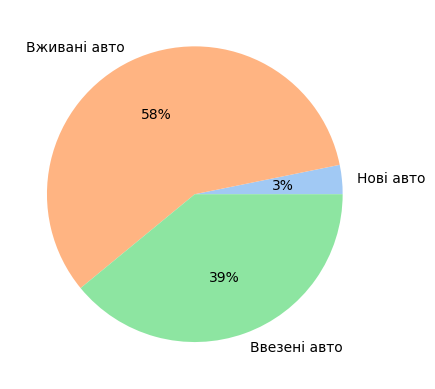

In [7]:
# Дані для діаграми
new_cars_quantity = new_cars.shape[0]
used_cars_quantity = used_cars.shape[0]
used_foreign_cars_quantity = used_foreign_cars.shape[0]

data = [new_cars_quantity, used_cars_quantity, used_foreign_cars_quantity]

# Підписи на діаграмі
labels = ["Нові авто", "Вживані авто", "Ввезені авто"]

# Кольори для діаграми
colors = sns.color_palette('pastel')[0:5]

# PIE CHART
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.savefig("diagrams/market.png")

#### 2.3 Поширеність класів автомобілів

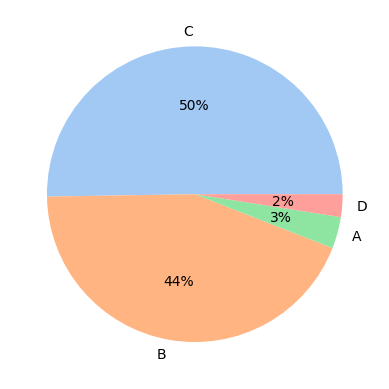

In [8]:
data = all_cars.groupby("CLASS")["VIN"].count().sort_values(ascending=False).reset_index().rename(columns={"VIN": "COUNT"})

# Кольори діаграми
colors = sns.color_palette('pastel')[0:5]

# PIE CHART
plt.pie(data["COUNT"], labels=data["CLASS"], colors=colors, autopct='%.0f%%')
plt.savefig("diagrams/classes.png")

#### 2.4 ТОП-10 моделей авто, які купували в автосалонах

In [9]:
new_cars.groupby(["BRAND", "MODEL"])["VIN"].count().sort_values(ascending=False).head(10)

BRAND       MODEL                 
RENAULT     DUSTER                    1857
TOYOTA      RAV4                      1523
            RAV-4 HYBRID               961
            LAND CRUISER PRADO 150     903
HYUNDAI     TUCSON                     834
CHERY       TIGGO 4                    714
MITSUBISHI  OUTLANDER                  687
KIA         SPORTAGE                   614
TOYOTA      CAMRY                      581
BMW         X5                         576
Name: VIN, dtype: int64

#### 2.5 ТОП-10 моделей авто, які купували на вторинному ринку

In [10]:
used_cars.groupby(["BRAND", "MODEL"])["VIN"].count().sort_values(ascending=False).head(10)

BRAND       MODEL  
VOLKSWAGEN  PASSAT     19123
DAEWOO      LANOS      12720
VOLKSWAGEN  GOLF       11989
SKODA       OCTAVIA    11120
CHEVROLET   AVEO        8613
RENAULT     MEGANE      8450
FORD        FOCUS       8439
TOYOTA      CAMRY       8177
SKODA       FABIA       8063
OPEL        ASTRA       6553
Name: VIN, dtype: int64

Середній вік придбаних на вторинному ринку ТЗ:

In [11]:
mean_year = used_cars["MAKE_YEAR"].mean()
mean_age = CURRENT_YEAR - mean_year

print(f"Середній вік придбаних на вторинному ринку ТЗ: {mean_age: .2f} років")

Середній вік придбаних на вторинному ринку ТЗ:  15.41 років


#### 2.6 ТОП-10 моделей авто, які ввозили з-за кордону

In [12]:
used_foreign_cars.groupby(["BRAND", "MODEL"])["VIN"].count().sort_values(ascending=False).head(10)

BRAND       MODEL        
VOLKSWAGEN  PASSAT           22395
            GOLF             20695
SKODA       OCTAVIA          15115
RENAULT     MEGANE           12585
FORD        FOCUS             9791
RENAULT     MEGANE SCENIC     9081
VOLKSWAGEN  TOURAN            9077
OPEL        ZAFIRA            8425
AUDI        A4                8304
OPEL        ASTRA             7172
Name: VIN, dtype: int64

Середній вік ввезених авто:

In [13]:
mean_year = used_foreign_cars["MAKE_YEAR"].mean()
mean_age = CURRENT_YEAR - mean_year

print(f"Середній вік ввезених ТЗ: {mean_age: .2f} років")

Середній вік ввезених ТЗ:  13.89 років


#### 2.7 Топ-10 моделей пікапів

In [14]:
pickup_trucks = all_cars[all_cars["BODY"] == "ПІКАП"]
pickup_trucks.groupby(["BRAND", "MODEL"])["VIN"].count().sort_values(ascending=False).head(10)

BRAND       MODEL   
MITSUBISHI  L 200       522
NISSAN      NAVARA      258
FORD        RANGER      120
            F 150       120
TOYOTA      HILUX        94
ЗАЗ         110557       75
TOYOTA      TUNDRA       54
VOLKSWAGEN  AMAROK       34
DODGE       RAM-1500     29
RAM         1500         28
Name: VIN, dtype: int64

#### 2.8 Топ-10 екологічних авто

In [15]:
eco_cars = all_cars[all_cars["FUEL"].isin(["ЕЛЕКТРО АБО БЕНЗИН", 
                                          "ЕЛЕКТРО АБО ДИЗЕЛЬНЕ ПАЛИВО", 
                                          "БЕНЗИН, ГАЗ АБО ЕЛЕКТРО", 
                                          "ЕЛЕКТРО", 
                                          "ГАЗ ТА ЕЛЕКТРО"])]

eco_cars.groupby(["BRAND", "MODEL"])["VIN"].count().sort_values(ascending=False).head(10)

BRAND      MODEL            
TOYOTA     RAV-4 HYBRID         1580
           PRIUS                1222
FORD       FUSION               1064
TOYOTA     CAMRY                1008
CHEVROLET  VOLT                  780
FORD       C-MAX                 646
TOYOTA     RAV4                  601
HYUNDAI    SONATA                433
VOLVO      XC90                  419
TOYOTA     HIGHLANDER HYBRID     408
Name: VIN, dtype: int64

#### 2.9 ТОП-10 люксових моделей авто

In [16]:
luxury_cars = all_cars[all_cars["CLASS"] == "D"]
luxury_cars.groupby(["BRAND", "MODEL"])["VIN"].count().sort_values(ascending=False).head(10)

BRAND       MODEL                 
TOYOTA      LAND CRUISER 200          1663
            LAND CRUISER PRADO 150     989
PORSCHE     CAYENNE                    953
LAND ROVER  RANGE ROVER                950
TOYOTA      LAND CRUISER               845
DODGE       JOURNEY                    801
JEEP        GRAND CHEROKEE             798
VOLKSWAGEN  TOUAREG                    581
BMW         X5                         574
LEXUS       LX 570                     523
Name: VIN, dtype: int64

#### 2.10 Машини якого кольору найчастіше купували?

In [17]:
all_cars.groupby("COLOR")["VIN"].count().sort_values(ascending=False).head(1)

COLOR
СІРИЙ    352091
Name: VIN, dtype: int64

#### 2.11 Машини з яким типом кузова найчастіше купували?

In [18]:
all_cars.groupby("BODY")["VIN"].count().sort_values(ascending=False).head(1)

BODY
УНІВЕРСАЛ    482815
Name: VIN, dtype: int64

#### 2.12 Машини з яким типом пального найчастіше купували?

In [19]:
all_cars.groupby("FUEL")["VIN"].count().sort_values(ascending=False).head(1)

FUEL
БЕНЗИН    434909
Name: VIN, dtype: int64

#### 2.13 Машини якого бренду купували найчастіше?

In [20]:
all_cars.groupby("BRAND")["VIN"].count().sort_values(ascending=False).head(3)

BRAND
VOLKSWAGEN    141622
RENAULT        68945
SKODA          56831
Name: VIN, dtype: int64

#### 2.14 В яких областях України найбільш активно реєстрували ТЗ?

In [21]:
all_cars.groupby("DISTRICT")["VIN"].count().sort_values(ascending=False).head(10)

DISTRICT
КИЇВ                 138048
ЛЬВІВСЬКА             98040
ДНІПРОПЕТРОВСЬКА      79540
ОДЕСЬКА               63567
КИЇВСЬКА              56832
ВІННИЦЬКА             48948
РІВНЕНСЬКА            46070
ІВАНО-ФРАНКІВСЬКА     44222
ВОЛИНСЬКА             43158
ЗАКАРПАТСЬКА          39636
Name: VIN, dtype: int64